In [2]:
import pandas as pd
df = pd.read_csv("tmdb_5000_movies.csv")
df.head(2)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [3]:
# Convert budget and revenue to numeric
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

# Convert release_date to datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Drop rows where both revenue and budget are missing or 0
df = df[(df['budget'] > 0) & (df['revenue'] > 0)]

# Create a new column for Hit or Flop
df['hit_or_flop'] = df['revenue'] > df['budget'] * 1.5


In [6]:
df.size

67809

In [12]:
import plotly.express as px

fig = px.scatter(df, x='budget', y='revenue',
                 color='hit_or_flop',
                 hover_data=['title', 'release_date'],
                 title='Budget vs Revenue (Hit vs Flop)',
                 labels={'hit_or_flop': 'Hit or Flop'})
fig.show()


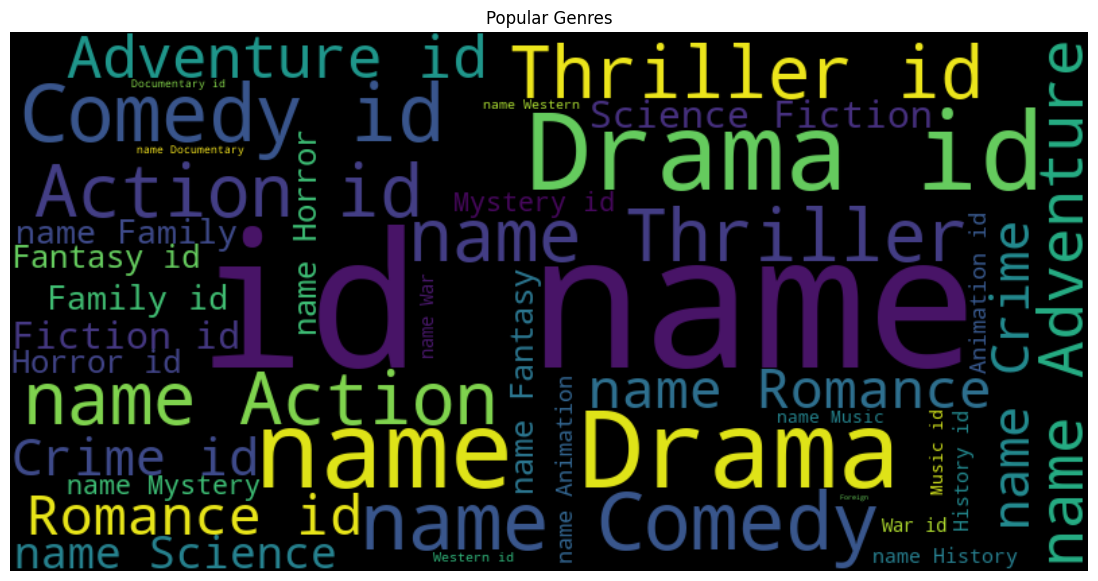

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all genres into one string for WordCloud
genre_text = ' '.join(df['genres'].dropna().astype(str))

# Create WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(genre_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Popular Genres')
plt.show()


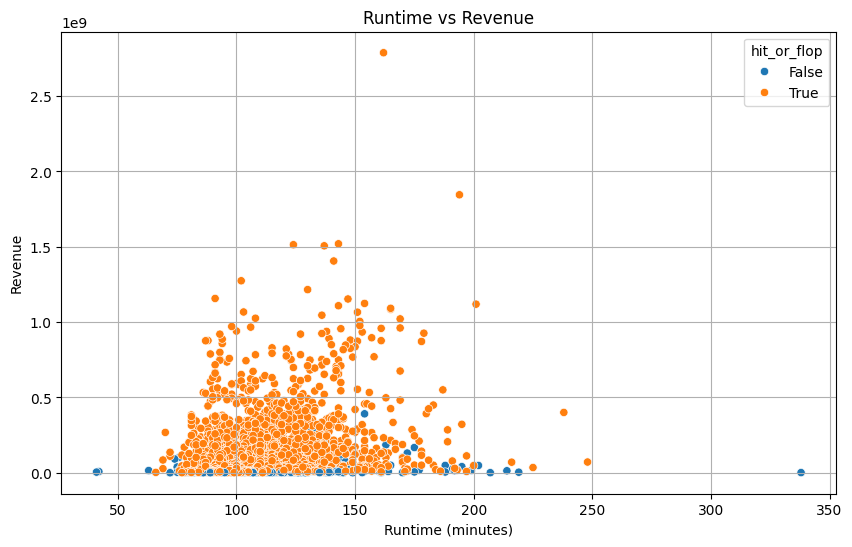

In [10]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='runtime', y='revenue', hue='hit_or_flop')
plt.title("Runtime vs Revenue")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()


In [13]:
lang_revenue = df.groupby('original_language')['revenue'].mean().sort_values(ascending=False).head(10)

fig = px.bar(x=lang_revenue.index, y=lang_revenue.values,
             title="Top 10 Languages by Average Revenue",
             labels={'x': 'Language', 'y': 'Avg Revenue'})
fig.show()


In [14]:
df['year'] = df['release_date'].dt.year
yearly_revenue = df.groupby('year')['revenue'].mean()

fig = px.line(x=yearly_revenue.index, y=yearly_revenue.values,
              title="Average Movie Revenue Over Time",
              labels={'x': 'Year', 'y': 'Avg Revenue'})
fig.show()


In [8]:
df['hit_or_flop'] = (df['revenue'] > df['budget'] * 1.5).astype(int)  # 1 = Hit, 0 = Flop


C:\Users\user\AppData\Local\Temp\ipykernel_5868\4234584374.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




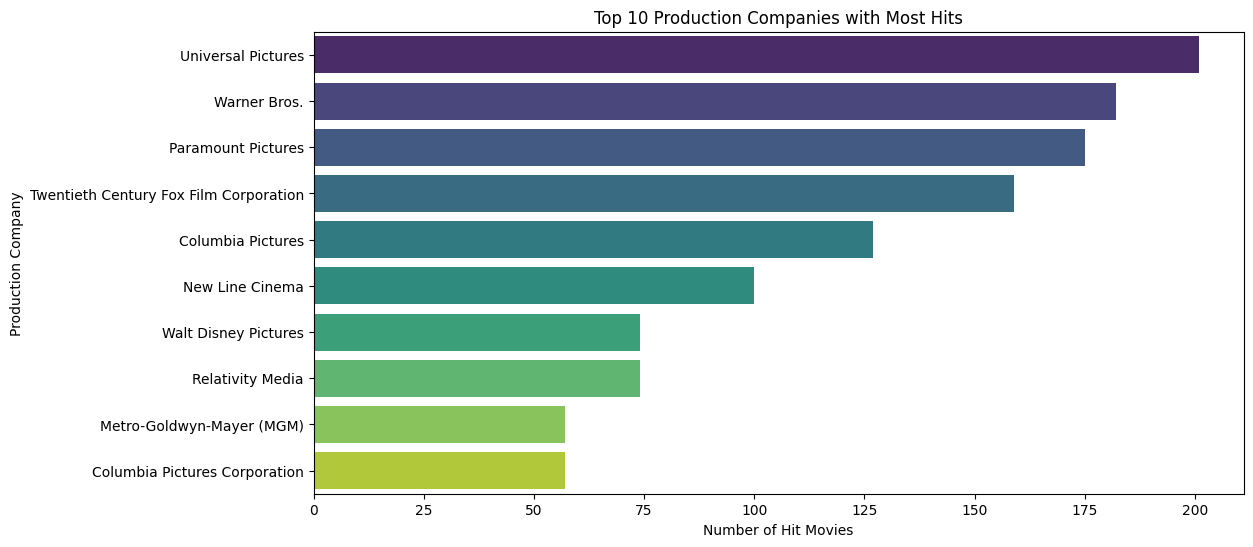

In [9]:
import ast

# Convert string to list of dicts
df['production_companies'] = df['production_companies'].fillna('[]').apply(ast.literal_eval)

# Flatten all production companies for each movie
from collections import Counter

company_counter = Counter()

for companies, is_hit in zip(df['production_companies'], df['hit_or_flop']):
    if is_hit:  # Only count if movie is a hit
        for company in companies:
            company_counter[company['name']] += 1

# Top 10 companies with most hits
top10 = company_counter.most_common(10)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

labels, values = zip(*top10)

plt.figure(figsize=(12,6))
sns.barplot(x=list(values), y=list(labels), palette='viridis')
plt.title('Top 10 Production Companies with Most Hits')
plt.xlabel('Number of Hit Movies')
plt.ylabel('Production Company')
plt.show()


In [23]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 1: Feature Engineering
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month

# Fill NA in 'genres' and 'production_companies'
df['genres'] = df['genres'].fillna('Unknown')
df['production_companies'] = df['production_companies'].fillna('Unknown')

import ast

def extract_main_genre(x):
    try:
        genres_list = ast.literal_eval(x)
        if isinstance(genres_list, list) and len(genres_list) > 0:
            return genres_list[0]['name']
        else:
            return 'Unknown'
    except:
        return 'Unknown'

def extract_main_company(x):
    try:
        companies_list = ast.literal_eval(x)
        if isinstance(companies_list, list) and len(companies_list) > 0:
            return companies_list[0]['name']
        else:
            return 'Unknown'
    except:
        return 'Unknown'

df['main_genre'] = df['genres'].apply(extract_main_genre)
df['main_company'] = df['production_companies'].apply(extract_main_company)


# Step 2: Select Features
features = [
    'budget', 'runtime', 'original_language', 'popularity', 'vote_average', 'vote_count',
    'release_year', 'release_month', 'main_genre', 'main_company'
]
X = df[features]
y = df['hit_or_flop']

# Step 3: Impute Missing & Encode
num_cols = X.select_dtypes(include='number').columns
cat_cols = X.select_dtypes(include='object').columns

X[num_cols] = SimpleImputer(strategy='mean').fit_transform(X[num_cols])
X = pd.get_dummies(X, columns=cat_cols)

# Step 4: Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Random Forest Tuning
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': ['balanced'],
    'random_state': [42, 52, 101],       # Optional: Try different seeds
    'max_samples': [0.7, 0.8, 0.9],      # Optional: Use subset of data
    'oob_score': [True]                  # Optional: Out-of-bag validation
}


rf_search = RandomizedSearchCV(
    rf_model,
    rf_param_grid,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=2
)
rf_search.fit(X_train, y_train)

# Step 6: Evaluate
best_rf = rf_search.best_estimator_
y_pred = best_rf.predict(X_test)

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")


C:\Users\user\AppData\Local\Temp\ipykernel_5868\326961374.py:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning:


160 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\AppDat


Accuracy: 0.7740

Confusion Matrix:
[[134  93]
 [ 53 366]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.59      0.65       227
           1       0.80      0.87      0.83       419

    accuracy                           0.77       646
   macro avg       0.76      0.73      0.74       646
weighted avg       0.77      0.77      0.77       646



C:\Users\user\AppData\Local\Temp\ipykernel_5868\2264237878.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




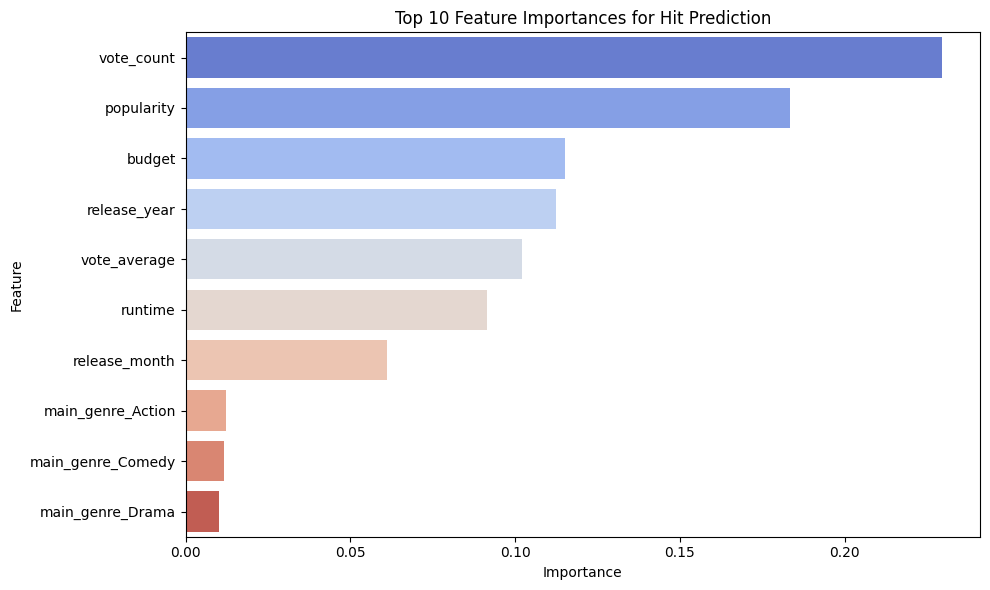

In [25]:
# Step 8: Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the best model
importances = best_rf.feature_importances_

# Create a pandas Series with the importances and sort them
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Plotting the top 10 most important features
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:10].values, y=feat_imp[:10].index, palette='coolwarm')
plt.title('Top 10 Feature Importances for Hit Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
